# Laboratorio 2 - Informe

### Grupo 4:
     - S. Calvo C.I 5.711.417-7     
     - X. Iribarnegaray C.I 5.253.705-9
     - J. Simonelli C.I 5.405.358-4

## 1. Objetivos
El objetivo de este laboratorio es:
- Implementar el algoritmo Naive Bayes
- Aplicar herramientas de metodología
- Analizar los resultados obtenidos.

## 2. Diseño
### 2.1 Algoritmo

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, auc, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt
from sklearn.base import ClassifierMixin, BaseEstimator
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_validate
from IPython.display import display

DATASET_FILE = "./lab1_dataset.csv"
dataset = pd.read_csv(DATASET_FILE, sep=",")
target = 'cid'
continuous_features = [
    'time',
    'age', 
    'wtkg', 
    'preanti', 
    'cd40', 
    'cd420', 
    'cd80', 
    'cd820'
]
features = [
    'time', 
    'trt', 
    'age', 
    'wtkg', 
    'hemo', 
    'homo', 
    'drugs', 
    'karnof',
    'oprior', 
    'z30', 
    'zprior', 
    'preanti', 
    'race', 
    'gender', 
    'str2', 
    'strat',
    'symptom', 
    'treat', 
    'offtrt', 
    'cd40', 
    'cd420', 
    'cd80', 
    'cd820'
]
dataset = dataset.drop(['pidnum'], axis=1)
print(dataset[target].value_counts())

cid
0    1618
1     521
Name: count, dtype: int64


### Implementación de Naive-Bayes

In [2]:
def naive_bayes(dataset, target, features, instance, m):
    dataset_size = dataset.shape[0]
    prob_1 = dataset[target].value_counts()[1]/dataset_size
    prob_0 = dataset[target].value_counts()[0]/dataset_size
    
    product_1 = prob_1
    product_0 = prob_0
    
    for feature in features:
        examples = dataset.loc[dataset[feature] == instance[feature]][target].value_counts()
        
        # if no instances with a specific target value is found, the get method will return 0
        count_1 = examples.get(1, default=0)
        count_0 = examples.get(0, default=0)
        
        feature_range = len(dataset[feature].value_counts())
        
        numerator_1 = count_1 + (m / feature_range)
        numerator_0 = count_0 + (m / feature_range)

        # product of sequence
        product_1 *= ( numerator_1 / (dataset[target].value_counts()[1] + m) )
        product_0 *= ( numerator_0 / (dataset[target].value_counts()[0] + m) )
        
    return (product_0/(product_0 + product_1), product_1/(product_0 + product_1))

Explicar implementación de arriba, explicitando que no retorna una clasificación, sino probabilidades de que de una clase o la otra

### Implementación de Naive-Bayes logarítmico

In [3]:
def naive_bayes_log(dataset, target, features, instance, m):
    dataset_size = dataset.shape[0]
    prob_1 = dataset[target].value_counts()[1]/dataset_size
    prob_0 = dataset[target].value_counts()[0]/dataset_size
    
    sum_1 = np.log(prob_1)
    sum_0 = np.log(prob_0)
    
    for feature in features:
        examples = dataset.loc[dataset[feature] == instance[feature]][target].value_counts()
        
        # if no instances with a specific target value is found, the get method will return 0
        count_1 = examples.get(1, default=0)
        count_0 = examples.get(0, default=0)
        
        feature_range = len(dataset[feature].value_counts())
        
        numerator_1 = count_1 + (m / feature_range)
        numerator_0 = count_0 + (m / feature_range)

        # sum of sequence
        sum_1 += np.log( numerator_1 / (dataset[target].value_counts()[1] + m) )
        sum_0 += np.log( numerator_0 / (dataset[target].value_counts()[0] + m) )
        
    return (np.exp(sum_0)/(np.exp(sum_0) + np.exp(sum_1)), np.exp(sum_1)/(np.exp(sum_0) + np.exp(sum_1)))

In [4]:
class CustomNaiveBayes(BaseEstimator, ClassifierMixin):
    def __init__(self, features, m):
        self.features = features
        self.m = m

    def fit(self, X_train, y_train):
        self.classes_ = np.unique(y_train)
        self.X_train = X_train.copy()
        self.y_train = y_train.copy()
        self.X_train[target] = y_train
        return self

    def predict(self, X_test):
        y_pred = []
        for i in range(0, X_test.shape[0]):
            instance = X_test.iloc[i]
            prob_0, prob_1 = naive_bayes(self.X_train, target, self.features, instance, self.m)
            if (prob_0 > prob_1):
                y_pred.append(0)
            else:
                y_pred.append(1)
        return np.array(y_pred)
    
    
    def __sklearn_clone__(self):
        return self

Por qué determinamos esta clase (representación interna de implementación de cross validation de scikit)


### 2.3 Evaluación

Explicar métricas de evaluación que vamos a usar (accuracy, recall, precision, f1_score) y por qué usamos average weighted de cada métrica (dataset desbalanceado).

## 3. Experimentación

### 3.1 Evaluación del hiperparametro m

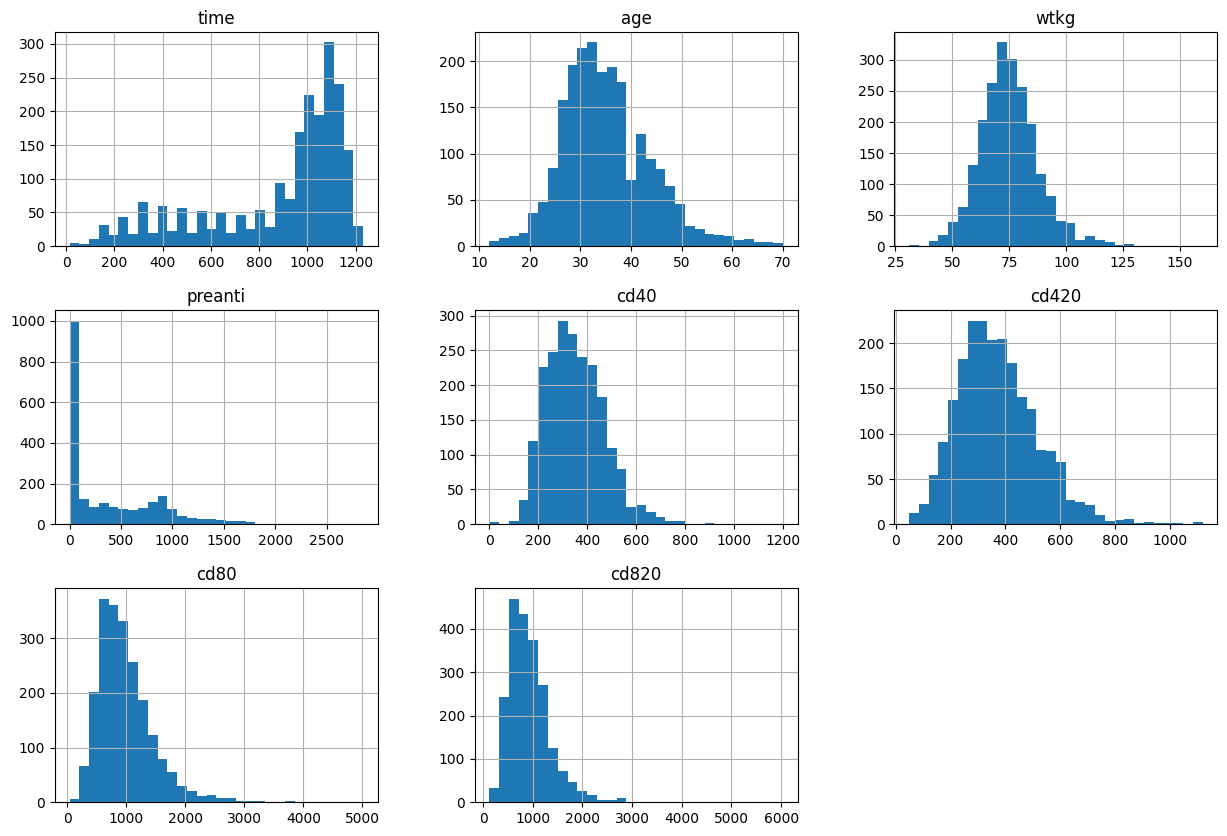

In [5]:
dataset[continuous_features].hist(bins=30, figsize=(15, 10))
plt.show()

In [6]:

# Initialize KBinsDiscretizer for continuous features
kbins = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')

# Discretize continuous features
dataset[continuous_features] = kbins.fit_transform(dataset[continuous_features])

# Prepare X and y
X = dataset.drop(target, axis=1)
y = dataset[target]

# List of m values
m_values = [1, 10, 100, 1000]

results = pd.DataFrame(columns=['m', 'Accuracy', 'Precision', 'Recall', 'F1'])

# Iterate over m values
for m in m_values:
    model = CustomNaiveBayes(features, m)
    scores = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'precision_weighted', 'recall_weighted','f1_weighted'] )
    results.loc[results.shape[0]] = [m, scores['test_accuracy'].mean(), scores['test_precision_weighted'].mean(), scores['test_recall_weighted'].mean(), scores['test_f1_weighted'].mean()]

def bold_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

styled_results = results.style.apply(bold_max, subset=['F1'])

display(styled_results)



,m,Accuracy,Precision,Recall,F1
0,1.000000,0.851315,0.848938,0.851315,0.849666
1,10.000000,0.852252,0.850432,0.852252,0.851069
2,100.000000,0.841971,0.836428,0.841971,0.836854
3,1000.000000,0.769518,0.782551,0.769518,0.686887


Hablar de preprocesamiento: KBins discretizer, por qué usamos kmeans para strategy\
Explicar el experimento (cross validation)\
Explicar resultados obtenidos (mejor m=10)

### 3.2 Evaluación de feature selection

,k,Accuracy,Precision,Recall,F1
0,1.000000,0.836449,0.839559,0.836449,0.837819
1,2.000000,0.827103,0.821334,0.827103,0.823152
2,3.000000,0.831776,0.828269,0.831776,0.829679
3,4.000000,0.848131,0.844169,0.848131,0.845467
4,5.000000,0.841121,0.836068,0.841121,0.837491
5,6.000000,0.848131,0.843227,0.848131,0.844383
6,7.000000,0.841121,0.834661,0.841121,0.835047
7,8.000000,0.848131,0.842582,0.848131,0.843233
8,9.000000,0.862150,0.857795,0.862150,0.858234
9,10.000000,0.850467,0.845514,0.850467,0.846501


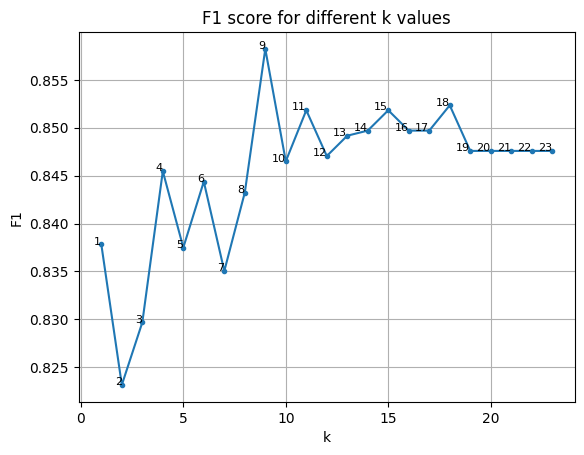

In [7]:
results = pd.DataFrame(columns=['k', 'Accuracy', 'Precision', 'Recall', 'F1'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
f1_array = []
k_array = list(range(1, 24))
for k in range(1,24):
    selector = SelectKBest(chi2, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    selected_features = X_train.columns[selector.get_support()]
    
    train_ds = X_train[selected_features].copy()
    train_ds[target] = y_train
    
    y_pred = []
    
    for i in range(0, X_test.shape[0]):
        instance = X_test.iloc[i]
        prob_0, prob_1 = naive_bayes(train_ds, target, selected_features, instance, 10)
        if (prob_0 > prob_1):
            y_pred.append(0)
        else:
            y_pred.append(1)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_array.append(f1)
    
    results.loc[results.shape[0]] = [k, accuracy, precision, recall, f1]

styled_results = results.style.apply(bold_max, subset=['F1'])

display(styled_results)

plt.plot(k_array, f1_array, marker='.')
plt.title('F1 score for different k values')
plt.xlabel('k')
plt.ylabel('F1')
plt.grid()
for i, f1_value in enumerate(f1_array):
    plt.text(k_array[i], f1_array[i], f'{k_array[i]}', fontsize=8, ha='right')

plt.show()

En este experimento tenemos como objetivo realizar un análisis de selección de atributos utilizando el algoritmo Naive Bayes con el hiperparámetro de suavizado *m* fijo en 10, que por el experimento anterior es el *m* con mejor F1 score. Se emplea la técnica de selección de atributos `SelectKBest` junto con la estrategia **Chi-Square** (chi2) para seleccionar los mejores atributos, y para cada posible *k* cantidad de mejores atributos del rango 1 a 23 se evalúan las métricas de rendimiento como **Aciertos**, **Precisión**, **Recuperación** y **Medida F1**.\
Respecto a la técnica de selcción de atributos usada, Chi-Square (chi2) se utiliza para evaluar la independencia de los atributos con respecto a la variable objetivo. Es particularmente efectiva cuando los atributos son categóricos, como en este caso después de la discretización de los atributos continuos mediante `KBinsDiscretizer`.\
\
Hemos obtenido que con el valor de **k=9** se obtiene la mejor Medida F1 de **0.858234**. Este resultado sugiere que, utilizando nueve atributos, el modelo alcanzó un balance adecuado entre precisión y recall. Además, es posible observar que la Medida F1 no crece directamente con la cantidad de atributos evaluados, sino que por lo visto fluctúa. Esto nos indica que la adición de atributos adicionales no necesariamente mejora la calidad del modelo.\
\
Comparando estos resultados con el modelo sin selección de atributos para **m=10**, el cual obtuvo un F1 de **0.851069**, observamos que la mejora en el F1 score utilizando selección de atributos con **k=9** (F1 = 0.858234) es marginal. Esto sugiere que la selección de atributos ayuda a mejorar el rendimiento, pero no de manera significativa en este caso. La diferencia es pequeña, lo que indica que el modelo completo, sin reducción de atributos, ya está capturando la mayoría de la información relevante. Sin embargo, utilizar una selección de atributos más pequeña podría seguir siendo beneficioso en términos de eficiencia, ya que la el algoritmo de Naive Bayes estaría efectuando menos cálculos para clasificar una instancia (menos productos o adiciones dependiendo de la implementación). Además, se logra simplificar el modelo y mejorar de la interpretabilidad al reducir la cantidad de variables y potencialmente eliminar redundancias.

In [17]:
selector = SelectKBest(chi2, k='all')
X_train_selected = selector.fit_transform(X_train, y_train)
selected_features = X_train.columns[selector.get_support()]

train_ds = X_train[selected_features].copy()
train_ds[target] = y_train

chi2_scores = selector.scores_

feature_scores = pd.DataFrame({
    'Feature': selected_features,
    'Chi2_Score': chi2_scores,
})

feature_scores_sorted = feature_scores.sort_values(by='Chi2_Score', ascending=False)
styled_results = feature_scores_sorted.style.apply(bold_max, subset=['Chi2_Score'])

display(styled_results)


,Feature,Chi2_Score
0,time,487.569962
20,cd420,211.352491
19,cd40,55.228008
11,preanti,47.215085
16,symptom,21.059162
1,trt,13.135860
21,cd80,10.376097
15,strat,9.025053
9,z30,8.650495
17,treat,8.618287


Una vez obtenidos los resultados del experimento anterior, realizamos un análisis más detallado de la importancia de cada uno de los atributos utilizando la técnica de Chi-Square para identificar cuáles de ellos tienen mayor relevancia para la predicción de la variable objetivo.\
De acuerdo con las puntuaciones obtenidas, los resultados muestran que el atributo time es el más relevante con un valor Chi2 de 487.56, seguido por cd420 (211.35) y preanti (55.22). Esto indica que estos atributos tienen una mayor influencia en la predicción de la clase objetivo. En el extremo opuesto, atributos como homo y zprior muestran puntuaciones muy bajas, lo que sugiere que tienen poca o ninguna relevancia para la predicción.

### 3.3 Curva de Precision-Recall

<Figure size 640x480 with 0 Axes>

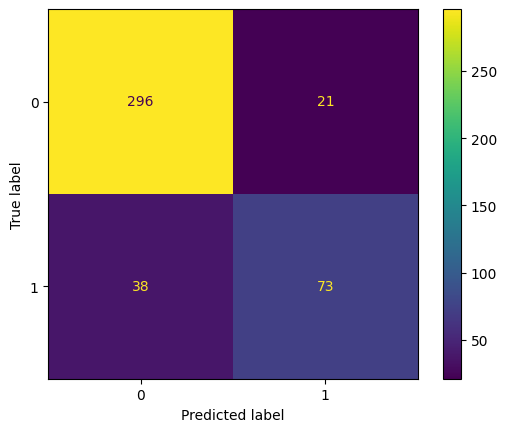

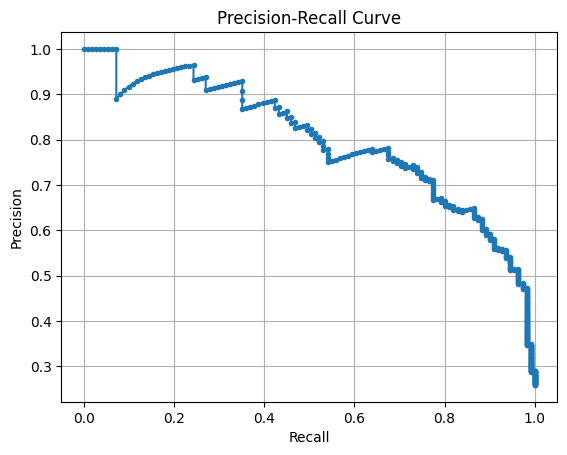

Area Under Curve: 0.7995841669429639



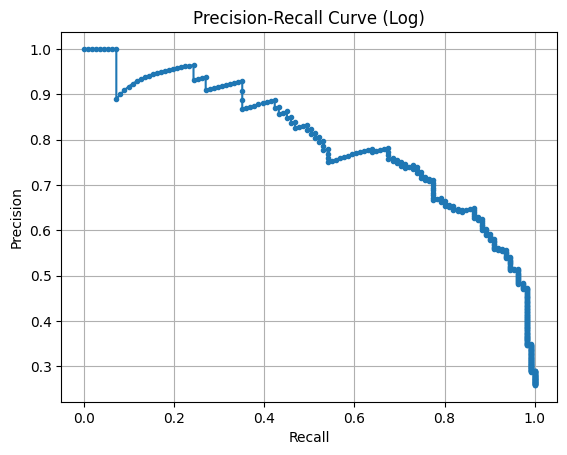

Area Under Curve (Log): 0.799584166942964



In [21]:
selector = SelectKBest(chi2, k=9)
X_train_selected = selector.fit_transform(X_train, y_train)
selected_features = X_train.columns[selector.get_support()]

train_ds = X_train[selected_features].copy()
train_ds[target] = y_train

y_score = []
y_score_log = []
y_pred = []

for i in range(0, X_test.shape[0]):
    instance = X_test.iloc[i]
    prob_0, prob_1 = naive_bayes(train_ds, target, selected_features, instance, 10)
    prob_log_0, prob_log_1 = naive_bayes_log(train_ds, target, selected_features, instance, 10)
    y_score.append(prob_1)
    y_score_log.append(prob_log_1)
    if (prob_0 > prob_1):
        y_pred.append(0)
    else:
        y_pred.append(1)
        
precision, recall, thresholds = precision_recall_curve(y_true=y_test, y_score=y_score)
precision_log, recall_log, thresholds_log = precision_recall_curve(y_true=y_test, y_score=y_score_log)

area_under_curve = auc(recall, precision)
area_under_curve_log = auc(recall_log, precision_log)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
plt.figure() 
disp.plot()
plt.show() 

# Precision-Recall Curve
plt.figure() 
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show() 
print(f"Area Under Curve: {area_under_curve}\n")

# Precision-Recall Curve (Log Scale)
plt.figure() 
plt.plot(recall_log, precision_log, marker='.')
plt.title('Precision-Recall Curve (Log)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()
print(f"Area Under Curve (Log): {area_under_curve_log}\n")


En este experimento, seleccionamos el mejor valor de **k** obtenido en los resultados anteriores, el cual es **k=9**. A partir de esto, seleccionamos los 9 atributos más relevantes utilizando la técnica de selección de atributos basada en Chi-Square y calculamos tanto la curva de precisión-recall como el área bajo la curva (AUC) para ambas implementaciones del algoritmo Naive Bayes: una versión tradicional basada en el producto de probabilidades, y una versión que utiliza las probabilidades en forma logarítmica. También calculamos la matriz de confusión para evaluar mejor el desempeño del modelo.\
\
Para la implementación tradicional de Naive Bayes (`naive_bayes`), calculamos las probabilidades a través del producto acumulativo de las probabilidades de cada atributo dado un valor de la clase objetivo. Esto funciona bien para conjuntos de datos reducidos o con pocos atributos, pero cuando el número de atributos es mayor, el producto de muchos valores pequeños puede llevar a problemas de desbordamiento numérico, ya que las probabilidades se hacen extremadamente pequeñas. En nuestro caso, con **k=9** no observamos problemas numéricos significativos debido al tamaño relativamente pequeño del conjunto de atributos.\
En la implementación logarítmica (`naive_bayes_log`), las probabilidades se manejan sumando los logaritmos de las probabilidades individuales, en lugar de multiplicarlas directamente. Esta técnica es conocida por su estabilidad numérica, ya que evita los problemas de desbordamiento asociados con la multiplicación de números pequeños. Sin embargo, al final del proceso, es necesario normalizar y transformar las probabilidades logarítmicas de vuelta a su forma exponencial para obtener probabilidades que se puedan comparar directamente.\
\
Al calcular la curva de precisión-recall para ambas versiones, observamos que los resultados obtenidos para ambas implementaciones son idénticos, como se muestra en las figuras anteriores. Ambas curvas tienen un área de aproximadamente **0.7996**, lo que indica que, desde el punto de vista de pérdida de datos, no es necesario utilizar la implementación logarítmica sobre la tradicional.\
\
La matriz de confusión nos muestra que la implementación logró predecir correctamente 296 de las instancias de la clase negativa y 73 de las instancias de la clase positiva, con 21 falsos positivos y 38 falsos negativos. Esto sugiere que, aunque el modelo es bastante preciso prediciendo la clase negativa, tiene más dificultad para identificar correctamente las instancias de la clase positiva. Esta tendencia también se refleja en la curva de precisión-recall, donde la precisión es alta para valores bajos de recall, pero disminuye a medida que el recall aumenta.


### Comparar con lab anterior